# imports

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

#  Load Data

In [11]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [12]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000


# One-hot encoding


In [13]:
data.test.labels[0:5, :]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [14]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

In [ ]:
data.test.cls[0:1]

#  Data dimensions

In [16]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of classes, one class for each of 10 digits.
num_classes = 10

# Helper-function for plotting images


In [17]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

# Plot a few images to see if data is correct

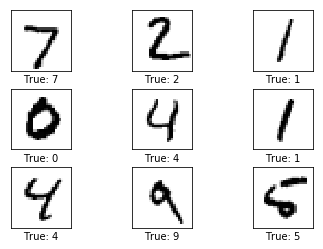

In [25]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

# Placeholder variables

Placeholder variables serve as the input to the graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.

In [20]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

In [23]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

In [24]:
y_true_cls = tf.placeholder(tf.int64, [None])

# Variables to be optimized

In [27]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

In [28]:
biases = tf.Variable(tf.zeros([num_classes]))

# Model

In [29]:
logits = tf.matmul(x, weights) + biases

In [31]:
y_pred = tf.nn.softmax(logits)

In [32]:
y_pred_cls = tf.argmax(y_pred, axis=1)

# Cost-function to be optimized

In [35]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y_true)

In [36]:
cost = tf.reduce_mean(cross_entropy)

# Optimization method

In [37]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

# Performance measures

In [38]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [39]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# TensorFlow Run

## Create TensorFlow session

In [40]:
session = tf.Session()

## Initialize variables

In [41]:
session.run(tf.global_variables_initializer())

## Helper-function to perform optimization iterations

In [43]:
batch_size = 100

In [45]:
def optimize(num_iterations):
    for i in range(num_iterations):
        # Get a batch of training examples.
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # Put the batch into a dict with the proper names
        feed_dict_train = {x: x_batch, y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        session.run(optimizer, feed_dict=feed_dict_train)


## Helper-functions to show performance

In [46]:
feed_dict_test = {x: data.test.images, y_true: data.test.labels, y_true_cls: data.test.cls}

In [47]:
def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [50]:
def plot_example_errors():
    # Use TensorFlow to get a list of boolean values
    # whether each test-image has been correctly classified,
    # and a list for the predicted class of each image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls], feed_dict=feed_dict_test)

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])


## Helper-function to plot the model weights

In [51]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


## Performance before any optimization

In [53]:
print_accuracy()

Accuracy on test-set: 9.8%


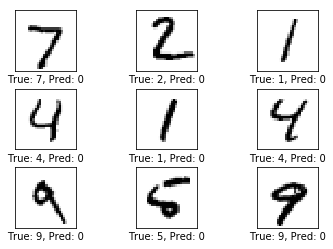

In [54]:
plot_example_errors()

## Performance after 1 optimization iteration

In [55]:
optimize(num_iterations=1)

In [56]:
print_accuracy()

Accuracy on test-set: 43.7%


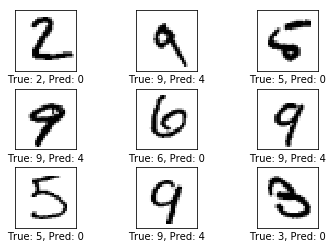

In [57]:
plot_example_errors()

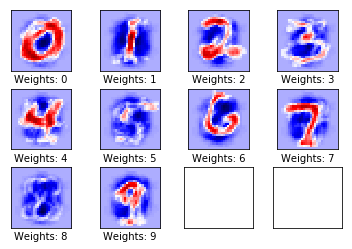

In [59]:
plot_weights()

## Performance after 10 optimization iterations

In [61]:
optimize(num_iterations=9)

In [62]:
print_accuracy()

Accuracy on test-set: 78.7%


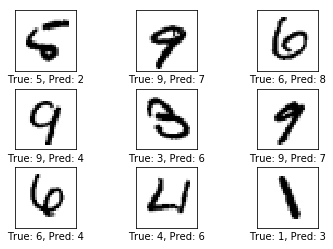

In [63]:
plot_example_errors()

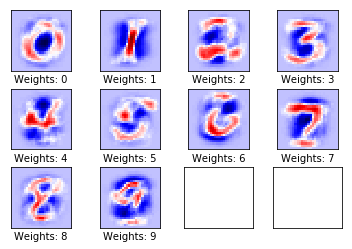

In [64]:
plot_weights()

## Performance after 1000 optimization iterations

In [65]:
optimize(num_iterations=990)

In [66]:
print_accuracy()

Accuracy on test-set: 91.8%


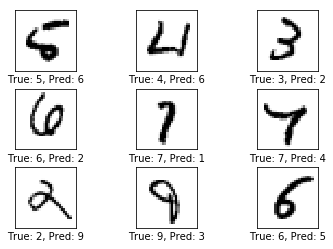

In [67]:
plot_example_errors()

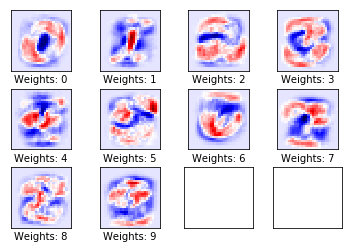

In [68]:
plot_weights()